# API project framework

Initialization:

In [1]:
import pydub as pd
import numpy as np

pd.AudioSegment.converter = "C:\\ffmpeg\\bin\\ffmpeg.exe"

Open file and show its size:

In [2]:
song = pd.AudioSegment.from_wav('sample8.wav')
test = song.get_array_of_samples()
np.size(test)

384000

Play the file:

In [3]:
song

Visualize the file:

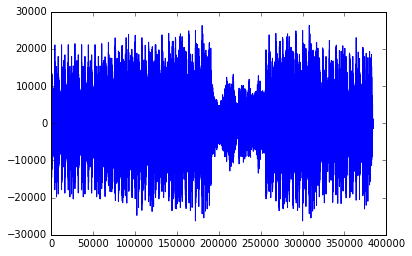

In [6]:
import matplotlib.pyplot as mp
% matplotlib inline

mp.plot(test)

Preprocessing:

In [7]:
n = 96
d = 4000

sample = np.zeros((n,d))

for i in range(n):
    index = d*i
    sample[i,:] = test[index:index+d]

np.shape(sample)

(96, 4000)

In [8]:
sample[95,:]

array([  47.,  -33.,  216., ..., -805., -733., -780.])

Statistics:

In [9]:
min = np.min(sample)
max = np.max(sample)

min,max

(-26275.0, 26260.0)

In [10]:
np.mean(sample), np.std(sample)

(-6.9813124999999996, 5675.8836952321199)

Normalization:

In [11]:
N = sample.shape[0] # count of samples
D = sample.shape[1] # dimensionality of observed space
Q = 20 # dimensionality of observed space

X = np.zeros((N,Q)) # Initialize the latent variable

#normilizing data:
sample_mean = np.mean(sample)
sample_std = np.std(sample)
sample_norm = (sample - sample_mean)/sample_std # normalization

print(sample_norm[0,:])

[ 0.00175855  0.00052526  0.00211092 ..., -0.00176513  0.00528223
 -0.00440789]


Gaussian process part:

In [12]:
import GPy

kernel = GPy.kern.Linear(Q,ARD=True)+GPy.kern.RatQuad(Q,ARD=True)+GPy.kern.RBF(Q,ARD=True)+GPy.kern.MLP(Q,ARD=True)+GPy.kern.Matern32(Q,ARD=True)
m = GPy.models.GPLVM(sample_norm, input_dim=Q, kernel=kernel, init='PCA')

In [13]:
m.optimize(messages=True, optimizer = 'SCG',max_iters=100)

 C:\Users\Maxim\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


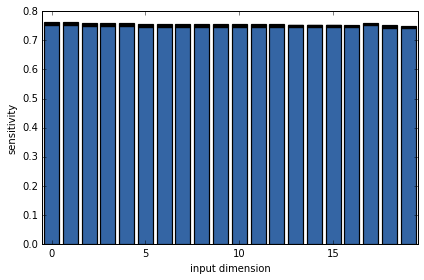

In [14]:
kernel.plot_ARD()

ValueError: total size of new array must be unchanged

 C:\Users\Maxim\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


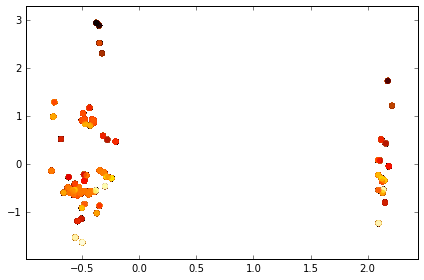

In [15]:
m.plot(visible_dims=(0,1))

In [16]:
X = m.X
print(X)

  index    |  GPLVM.latent_mean  |  constraints  |  priors
  [0 0]    |        -0.46570914  |               |        
  [0 1]    |        -0.56583302  |               |        
  [0 2]    |        -0.04967768  |               |        
  [0 3]    |        -0.12274315  |               |        
  [0 4]    |         0.06728762  |               |        
  [0 5]    |        -0.15744565  |               |        
  [0 6]    |         0.08846797  |               |        
  [0 7]    |        -0.34356180  |               |        
  [0 8]    |        -0.09917918  |               |        
  [0 9]    |        -0.34026864  |               |        
  [ 0 10]  |        -0.00646803  |               |        
  [ 0 11]  |        -0.52508630  |               |        
  [ 0 12]  |         0.30101000  |               |        
  [ 0 13]  |        -0.06596452  |               |        
  [ 0 14]  |         0.31893822  |               |        
  [ 0 15]  |        -0.95906744  |               |      

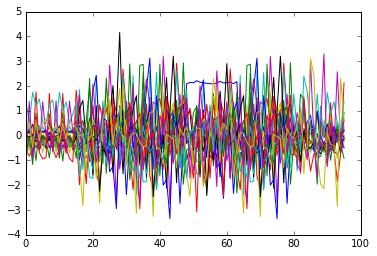

In [17]:
mp.plot(X)

In [ ]:
Kx = kernel.K(X[0:N-1])
print(Kx)

In [ ]:
def predict_new_latent_frame(N,X,kern,Kx_inv,X_old):
    
    k_x = kern.K(X[0:N-1],X_old)
    #k_xx = kern.K(X_old,X_old)

    meann = np.matmul(np.matmul(np.transpose(X[1:N]),Kx_inv),k_x).flatten()
    #cov = (k_xx - np.matmul(np.matmul(np.transpose(k_x),Kx_inv),k_x)) * np.eye(Q)
    
    #R = np.random.multivariate_normal(meann,cov)
    R = meann
    
    return R

In [ ]:
N_synt = 100
X_synt = np.zeros((N_synt,Q))
X_last = X[N-1:N]
Kx_inv = np.linalg.inv(Kx)

for i in range(N_synt):
    X_synt[i,:] = predict_new_latent_frame(N,X,kernel,Kx_inv,X_last.reshape(1,Q))
    X_last = X_synt[i,:]
    
print(X_synt)

In [ ]:
mp.plot(X_synt)

In [14]:
Y_synt = np.zeros((N_synt,D))

Ky = kernel.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample_norm)
k_y = kernel.K(X,X_synt)
k_yy = kernel.K(X_synt,X_synt)

meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)
cov = (k_yy - np.matmul(np.matmul(np.transpose(k_y),Ky_inv),k_y))


for i in range(D):
    Y_synt[:,i] = np.matmul(cov,np.random.randn(N_synt)) + meann[i,:]

print(Y_synt)

NameError: name 'N_synt' is not defined

In [15]:
np.min(Y_synt), np.max(Y_synt)

NameError: name 'Y_synt' is not defined

In [22]:
np.mean(Y_synt), np.std(Y_synt)

(4.07261619812388, 394.1494029251939)

In [23]:
max = np.max(Y_synt)
min = np.min(Y_synt)
max,min

(1780.4046110794777, -1988.4151643050072)

In [24]:
Y_synt_denorm = (65536/(max - min))*(Y_synt)

print(Y_synt_denorm)

[[  5.34107880e+02   4.68661737e+01   2.70645012e+02 ...,  -6.61952551e+02
   -2.67459595e+02  -3.88321747e+02]
 [ -2.76811311e+00  -6.07232294e+00  -1.18983145e+01 ...,  -1.82013605e+00
    1.00444455e+01   7.56399325e-01]
 [  1.22961801e+01   3.20065479e+00  -6.53423491e+00 ...,  -1.21369633e+01
   -8.26955337e+00  -1.06934295e+01]
 ..., 
 [ -7.09186577e+02   3.80459514e+03  -8.19684241e+03 ...,   1.87432390e+03
    6.72370351e+03   4.26405741e+02]
 [ -7.09186055e+02   3.80459714e+03  -8.19684358e+03 ...,   1.87432480e+03
    6.72370691e+03   4.26405490e+02]
 [ -7.09186323e+02   3.80459654e+03  -8.19683530e+03 ...,   1.87432385e+03
    6.72370123e+03   4.26403520e+02]]


In [25]:
np.min(Y_synt_denorm), np.max(Y_synt_denorm)

(-34576.547559799088, 30959.452440200912)

In [26]:
np.mean(Y_synt_denorm), np.std(Y_synt_denorm)

(70.818715424782496, 6853.8632276387643)

In [27]:
sample_synt = np.zeros(N_synt*d)
for i in range(N_synt):
    index = i*d
    sample_synt[index:index+d] = Y_synt_denorm[i,:]

sample_synt

array([  534.10787968,    46.86617373,   270.64501184, ...,  1874.32384658,
        6723.70123398,   426.40351979])

In [28]:
test_synt = pd.AudioSegment(
    sample_synt.tobytes(), 
    frame_rate=8000,
    sample_width=2, 
    channels=1
)

In [29]:
test_synt

In [442]:
test_synt.export("test.wav", format="wav")

<_io.BufferedRandom name='test.wav'>